**STEP 0: SETUP**
*   Setup the environment here.
*   Install/Import libraries as needed.
*   Mount drive(s)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from __future__ import absolute_import, division, print_function
import pathlib
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot  as plt
from google.colab import files
print(tf.__version__)

2.15.0


In [ ]:
#!pip install torch

In [ ]:
import yfinance as yf

In [ ]:
!pip install pandas-ta
import pandas_ta as pta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=598fe86812bceb899dec30db1e18c76303dbb0236c21b4ea4ed94d1aff3743fe
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [ ]:
!pip install ta
import ta
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
from ta.trend import ADXIndicator
from ta.volatility import BollingerBands
from ta.volatility import AverageTrueRange

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=b84005d7461e11be011a3af5a3e236d175d5d09c3f8fe5a3c5fcadb75977ffd2
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#df = {'Open': 1445.700012, 'High':1456.500000,'Low':1426.549988, 'Close' : 1427.000012,	'Adj Close':1427.700012,'Volume':	20872940}
#data = data._append(pd.DataFrame(df, index=['2024-05-09 00:00:00']))

**STEP 1: PREPROCESSING**
*   Fetch Data and process it to derive more data
*   Cleanup the data to make it ready for the next step


In [ ]:
tkr = 'CANBK.NS'
data = yf.download(tkr, start='2019-01-01', end='2024-12-31')
#data = yf.download(tkr, start='2023-01-01', end='2023-07-20')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,276.500000,283.399994,274.299988,281.500000,261.845459,5419071
2019-01-02,280.200012,283.700012,273.600006,275.399994,256.171356,5644563
2019-01-03,275.899994,278.399994,273.350006,276.299988,257.008514,3993439
2019-01-04,278.000000,285.500000,274.200012,282.950012,263.194214,6138056
2019-01-07,284.700012,286.450012,276.850006,278.250000,258.822357,3551975
...,...,...,...,...,...,...
2024-05-07,595.349976,596.750000,572.000000,576.750000,576.750000,8655201
2024-05-08,579.700012,598.500000,554.049988,557.700012,557.700012,22872940
2024-05-09,563.000000,568.000000,542.000000,545.500000,545.500000,13121161


In [ ]:
psar_obj = ta.trend.PSARIndicator(data['High'],data['Low'],data['Close'], fillna=True)
df = psar_obj.psar()
df1 = psar_obj.psar_up()
df2 = psar_obj.psar_down()
df.rename('ta-psar', inplace=True)
df1.rename('ta-psar-up', inplace=True)
df2.rename('ta-psar-dn', inplace=True)
data = pd.concat([data, df, df1, df2], axis=1)
#data[['ta-psar', 'ta-psar-up', 'ta-psar-dn']]

In [ ]:
#MACD uisng TA Pkg
macd_obj = ta.trend.MACD(data['Adj Close'])
data['ta-macd'] = macd_obj.macd()
data['ta-macd-sig'] = macd_obj.macd_signal()
data['ta-macd-sig-%'] = data['ta-macd']/data['ta-macd-sig']
#Histogram or diff is same
data['ta-macd-hgram'] = macd_obj.macd_diff()

#STC OSCILLATOR using PANDAS TA pkg
df = pta.stc(data['Adj Close'], fillna=False)
df.rename(columns={'STC_10_12_26_0.5':'pta-stc','STCmacd_10_12_26_0.5':'pta-stc-macd','STCstoch_10_12_26_0.5':'pta-stc-stoch' }, inplace=True)
data = pd.concat([data, df], axis=1)
data['pta-stc%-25'] = data['pta-stc']/25
data['pta-stc-stoch%-20'] = data['pta-stc-stoch']/20
#data


In [ ]:
#Calculate 'Up from 52 wk low' and 'down from 52 wk high'
def updn_52wk(df):
  max52 = df['Adj Close'].rolling(window=260).max().shift(1)
  min52 = df['Adj Close'].rolling(window=260).min().shift(1)
  dn = 1 - (df['Adj Close']/max52)
  up = (df['Adj Close']/min52) - 1
  return dn, up

data['dn52wk'], data['up52wk'] = updn_52wk(data)
#data

In [ ]:
#RSI using Pandas TA package
df1 = pta.rsi(data['Adj Close'])
df1.rename('pta-rsi', inplace=True)
data = pd.concat([data, df1], axis=1)
data['pta-rsi%-25'] = data['pta-rsi']/25.0

#Stoch indicator using Pandas TA pkg
df = pta.stoch(data['High'],data['Low'],data['Close'])
df.rename(columns={'STOCHk_14_3_3':'pta-stochk','STOCHd_14_3_3':'pta-stochd'}, inplace=True)
data = pd.concat([data, df], axis=1)
data['pta-stochk%-20'] = data['pta-stochk']/20
data['pta-stochd%-20'] = data['pta-stochd']/20
#Stochastic Oscillator using TA pkg
stoch = StochasticOscillator(data['High'],data['Low'],data['Close'])
data['ta-stoch'] = stoch.stoch()
data['ta-stoch%-20'] = data['ta-stoch']/20

#AROON using Pandas TA pkg
df = pta.aroon(data['High'],data['Low'], length=25, talib=False, scalar = 1)
df.rename(columns={'AROOND_25':'pta-aroond','AROONU_25':'pta-aroonu','AROONOSC_25':'pta-aroon-osc'}, inplace=True)
data = pd.concat([data, df], axis=1)

In [ ]:
data

In [ ]:
# PTA Supertrend calculator
df = pta.supertrend(data['High'],data['Low'],data['Close'])
df.rename(columns={'SUPERT_7_3.0':'pta-supertrend','SUPERTd_7_3.0':'pta-supertrend-dir','SUPERTl_7_3.0':'pta-supertrend-l', 'SUPERTs_7_3.0':'pta-supertrend-s'}, inplace=True)
df = df.drop(['pta-supertrend-l','pta-supertrend-s'], axis=1)
data = pd.concat([data, df], axis=1)

In [ ]:
data

In [ ]:
#ADX using Pandas TA pkg
df = pta.adx(data['High'],data['Low'],data['Close'])
df.rename(columns={'ADX_14':'pta-adx','DMP_14':'pta-adx-dmp','DMN_14':'pta-adx-dmn'}, inplace=True)
data = pd.concat([data, df], axis=1)

data['pta-adx%-25'] = data['pta-adx']/25
data['pta-adx-pn%'] = data['pta-adx-dmp']/data['pta-adx-dmn']

#ATR using Pandas TA pkg
df1 = pta.atr(data['High'],data['Low'],data['Close'])
df1.rename('pta-atr', inplace=True)
data = pd.concat([data, df1], axis=1)
data['pta-atr%'] = data['pta-atr']/data['Adj Close']

In [ ]:
data

In [ ]:
# Bollinger Bands using TA pkg
bollinger = BollingerBands(data['Adj Close'])
data['ta-boll-mva'] = bollinger.bollinger_mavg()
data['ta-boll-hband'] = bollinger.bollinger_hband()
data['ta-boll-lband'] = bollinger.bollinger_lband()
data['ta-boll-hb-ind'] = bollinger.bollinger_hband_indicator()
data['ta-boll-lb-ind'] = bollinger.bollinger_lband_indicator()
data['ta-boll-mva%'] = data['Adj Close']/data['ta-boll-mva']
data['ta-boll-hb%'] = data['Adj Close']/data['ta-boll-hband']
data['ta-boll-lb%'] = data['Adj Close']/data['ta-boll-lband']

#On Balance Vol
from ta.volume import OnBalanceVolumeIndicator
obv = OnBalanceVolumeIndicator(data['Adj Close'], data['Volume'])
data['ta-obv'] = obv.on_balance_volume()
data['ta-obv%'] = data['ta-obv']/data['ta-obv'].shift()

#VWAP Indicator from Pandas TA pkg
df = pta.vwap(data['High'],data['Low'],data['Close'], data['Volume'])
df1.rename('pta-vwap', inplace=True)
data = pd.concat([data, df1], axis=1)
data['pta-vwap%'] = data['Adj Close']/data['pta-vwap']

In [ ]:
data['sma10'] = data['Adj Close'].rolling(10).mean()
data['sma30'] = data['Adj Close'].rolling(30).mean()
data['sma50'] = data['Adj Close'].rolling(50).mean()
data['sma200'] = data['Adj Close'].rolling(200).mean()
data['ema20'] = data['Adj Close'].ewm(span=20).mean()
data['ema200'] = data['Adj Close'].ewm(span=200).mean()

data['sma10%'] =  data['Adj Close']/data['sma10']
data['sma30%'] =  data['Adj Close']/data['sma30']
data['sma50%'] =  data['Adj Close']/data['sma50']
data['sma200%'] =  data['Adj Close']/data['sma200']
data['ema20%'] =  data['Adj Close']/data['ema20']
data['ema200%'] =  data['Adj Close']/data['ema200']

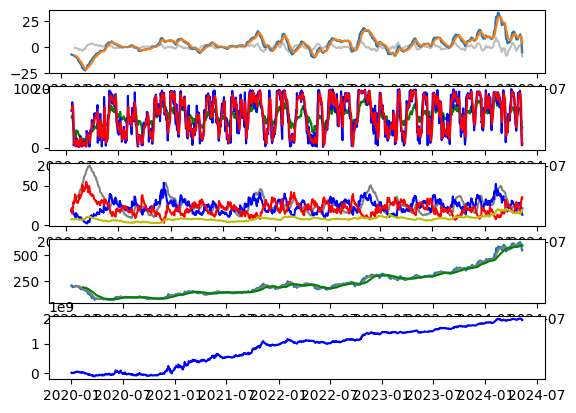

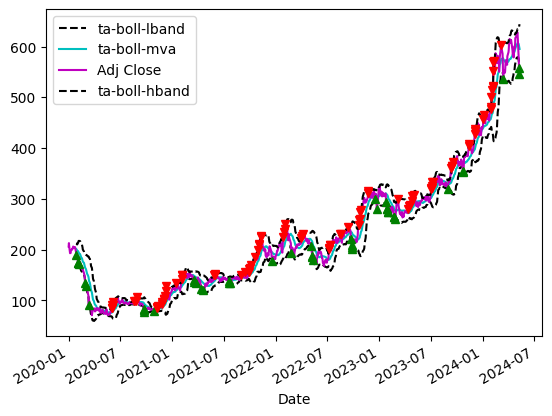

In [ ]:
plt.subplot(5,1,1)
plt.plot(data['ta-macd'])
plt.plot(data['ta-macd-sig'])
#plt.plot(data['ta-momentum'])
plt.plot(data['ta-macd-hgram'], color='grey', alpha = 0.5)

plt.subplot(5,1,2)
plt.plot(data['pta-rsi'], color='g')
plt.plot(data['ta-stoch'], color='b')
plt.plot(data['pta-stochk'], color='r')
#plt.plot(data['pta-stochd'], color='r')

plt.subplot(5,1,3)
plt.plot(data['pta-adx'], color='grey')
plt.plot(data['pta-adx-dmp'], color='b')
plt.plot(data['pta-adx-dmn'], color='r')
plt.plot(data['pta-atr'], color='y')

plt. subplot(5,1,4)
plt.plot(data['Adj Close'])
plt.plot(data['sma10'], color='grey')
plt.plot(data['sma30'], color='g')
#plt.plot(data['sma100'], color='r')
#plt.plot(data['ta-sma200'], color='y')

plt.subplot(5,1,5)
#plt.plot(data['ta-adi'], color='r')
plt.plot(data['ta-obv'], color='b')

data[['ta-boll-lband', 'ta-boll-mva', 'Adj Close', 'ta-boll-hband']].plot(style=['k--', 'c-', 'm-', 'k--'])
plt.plot(data[data['ta-boll-lb-ind']==1]['Adj Close'], '^g')
plt.plot(data[data['ta-boll-hb-ind']==1]['Adj Close'], 'vr')
#plt.title('Bollinger Bands Entries')



In [ ]:
data['Bullish_Run_Start'] = (data['ta-macd'] > data['ta-macd-sig']) & (data['ta-macd'].shift(1) <= data['ta-macd-sig'].shift(1))
data['Bearish_Run_Start'] = (data['ta-macd'] < data['ta-macd-sig']) & (data['ta-macd'].shift(1) >= data['ta-macd-sig'].shift(1))

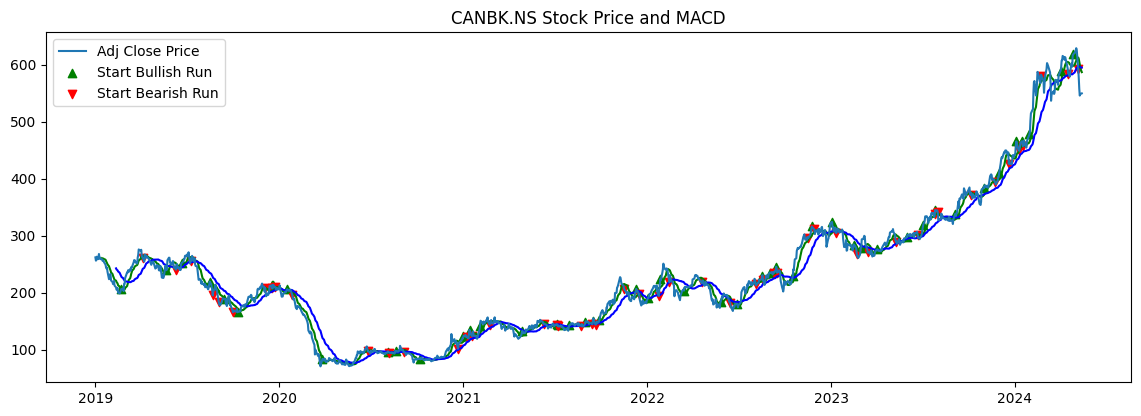

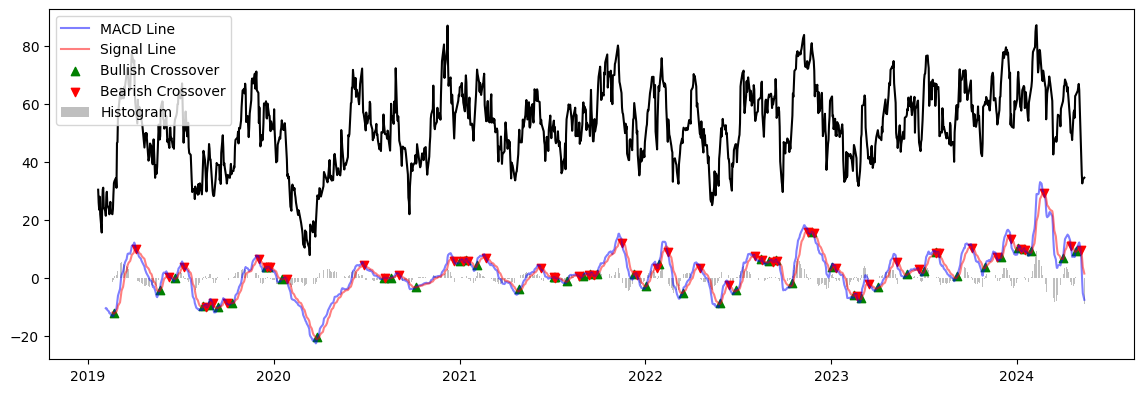

In [ ]:
# Plot
plt.figure(figsize=(14, 10))

#Plot Close Price
plt.subplot(2, 1, 1)
plt.plot(data['sma10'], color = 'g')
plt.plot(data['sma30'], color = 'b')
plt.plot(data['Adj Close'], label='Adj Close Price')
plt.scatter(data.index[data['Bullish_Run_Start']], data['Adj Close'][data['Bullish_Run_Start']], marker='^', color='g', label='Start Bullish Run')
plt.scatter(data.index[data['Bearish_Run_Start']], data['Adj Close'][data['Bearish_Run_Start']], marker='v', color='r', label='Start Bearish Run')
plt.title(tkr + ' Stock Price and MACD')
plt.legend()


# Identify bullish and bearish crossover points
data['Bullish_Crossover'] = (data['ta-macd'] > data['ta-macd-sig']) & (data['ta-macd'].shift(1) <= data['ta-macd-sig'].shift(1))
data['Bearish_Crossover'] = (data['ta-macd'] < data['ta-macd-sig']) & (data['ta-macd'].shift(1) >= data['ta-macd-sig'].shift(1))

# Plot
plt.figure(figsize=(14, 10))

# Plot MACD
plt.subplot(2, 1, 2)
plt.plot(data['ta-macd'], label='MACD Line', color='blue', alpha=0.5)
plt.plot(data['ta-macd-sig'], label='Signal Line', color='red', alpha=0.5)
plt.bar(data.index, data['ta-macd-hgram'], label='Histogram', color='grey', alpha=0.5)

# Markers for bullish and bearish crossover
plt.scatter(data.index[data['Bullish_Crossover']], data['ta-macd'][data['Bullish_Crossover']], marker='^', color='g', label='Bullish Crossover')
plt.scatter(data.index[data['Bearish_Crossover']], data['ta-macd'][data['Bearish_Crossover']], marker='v', color='r', label='Bearish Crossover')
plt.plot(data['pta-rsi'], color='k')
plt.legend()
plt.show()

#plt.subplot(3,1,2)
#plt.plot(biocon['ta-macd'])
#plt.plot(biocon['ta-macd-sig'])
#plt.plot(biocon['ta-macd-diff'], color='grey', alpha = 0.5)
#plt. subplot(3,1,3)
#plt.plot(biocon['ta-rsi'], color='g')


In [ ]:
dta_copy = data.copy()
#data.dropna(inplace=True)

In [ ]:
#data = dta_copy.copy()
#data

In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,ta-psar,ta-psar-up,ta-psar-dn,ta-macd,...,sma50,sma200,ema20,ema200,sma10%,sma30%,sma50%,sma200%,ema20%,ema200%
count,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1.323000e+03,1323.000000,1323.000000,1323.000000,1298.000000,...,1274.000000,1124.000000,1323.000000,1323.000000,1314.000000,1294.000000,1274.000000,1124.000000,1323.000000,1323.000000
mean,240.905593,244.859902,236.678723,240.600151,230.567590,1.183786e+07,239.210533,234.842422,243.328572,1.832372,...,223.479951,205.405187,228.207243,212.644338,1.003146,1.012776,1.023193,1.095325,1.005725,1.052978
std,116.547619,117.722726,115.072139,116.429664,118.718096,9.926699e+06,113.604119,111.183888,114.395710,7.473565,...,108.380683,83.767254,113.957780,80.415728,0.047214,0.093818,0.125419,0.261536,0.063935,0.216837
min,76.400002,78.300003,73.650002,76.099998,70.786636,5.215490e+05,73.650002,73.650002,85.161690,-22.515247,...,79.201041,90.450628,75.958112,105.044564,0.743705,0.531802,0.449594,0.359080,0.628399,0.380622
25%,156.025002,158.174995,153.625000,155.775002,144.898682,5.955534e+06,154.976052,153.345024,158.347249,-2.107509,...,142.205800,137.243352,143.191678,139.595601,0.977120,0.965107,0.962497,0.944849,0.974918,0.936450
50%,224.399994,227.850006,220.399994,223.500000,209.522873,8.663129e+06,221.220999,219.680029,229.403692,1.521174,...,204.044115,196.253948,207.274155,205.111417,1.002075,1.014989,1.030954,1.140816,1.008700,1.090946
75%,295.450012,299.425003,290.925003,295.049988,283.758347,1.368126e+07,295.262641,283.285517,299.350006,5.904622,...,281.543580,253.372382,281.187908,254.571141,1.031567,1.066221,1.098621,1.283919,1.042847,1.196865
max,632.900024,632.900024,623.049988,628.599976,628.599976,8.738601e+07,632.900024,586.548662,632.900024,33.039457,...,586.253003,450.934250,605.230987,473.558071,1.262964,1.413950,1.458440,1.575700,1.312476,1.540151


In [ ]:

data = data.drop(['ta-macd', 'ta-macd-sig', 'pta-stc', 'pta-stc-stoch'], axis = 1)
data = data.drop(['pta-rsi', 'ta-stoch','pta-stochk', 'pta-stochd'], axis = 1)
data = data.drop(['pta-adx-dmn', 'pta-adx','pta-adx-dmp', 'pta-atr'], axis = 1)
data = data.drop(['ta-boll-mva', 'ta-boll-hband','ta-boll-lband','ta-obv', 'pta-vwap'], axis = 1)
data = data.drop(['sma10', 'sma30','sma50','sma200', 'ema20','ema200', 'sma200%'], axis = 1)
data = data.drop(['Open', 'Close', 'High', 'Low','Bullish_Run_Start', 'Bearish_Run_Start', 'Bullish_Crossover', 'Bearish_Crossover'], axis = 1)
#data.dropna(inplace=True)
#data

In [ ]:
data = data.drop(['Volume', 'ta-psar-up', 'ta-psar-dn', 'pta-stc-macd','pta-supertrend', 'pta-supertrend-dir', 'ta-boll-hb-ind', 'ta-boll-lb-ind'], axis = 1)


In [ ]:
data = data.drop(['ta-boll-mva%', 'ta-boll-hb%','ta-boll-lb%','ta-obv%', 'pta-vwap%'], axis = 1)

In [ ]:
#data.dropna(inplace=True)
data.dtypes

Adj Close            float64
ta-psar              float64
ta-macd-sig-%        float64
ta-macd-hgram        float64
pta-stc%-25          float64
pta-stc-stoch%-20    float64
dn52wk               float64
up52wk               float64
pta-rsi%-25          float64
pta-stochk%-20       float64
pta-stochd%-20       float64
ta-stoch%-20         float64
pta-aroond           float64
pta-aroonu           float64
pta-aroon-osc        float64
pta-adx%-25          float64
pta-adx-pn%          float64
pta-atr%             float64
sma10%               float64
sma30%               float64
sma50%               float64
ema20%               float64
ema200%              float64
dtype: object

In [ ]:
#function to create the output for ANN
def get_output(df, period=7):
  df['ret'] = df['Adj Close'].rolling(period).max().shift(-1*(period))
  #print(df)
  #df.dropna(inplace=True)
  df['ret%'] = df['ret'].sub(df['Adj Close']).div(df['Adj Close']).mul(100)
  df = df.drop('ret', axis=1)
  #df['ret%'] = df['ret%'].rolling(period).mean()
  return df

data = get_output(data, period=7)
data.dropna(inplace=True)

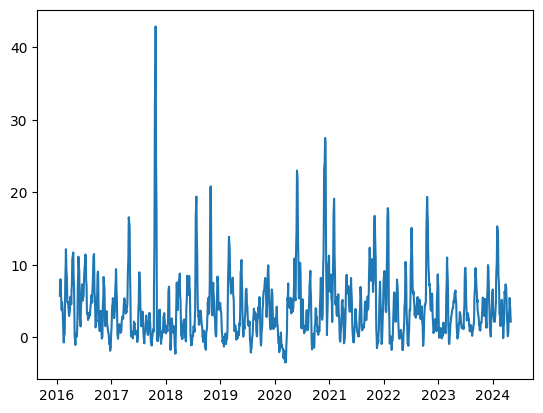

In [ ]:
plt.plot(data['ret%'])

In [ ]:
data

,Adj Close,Volume,ta-psar,ta-psar-up,ta-psar-dn,ta-macd-sig-%,ta-macd-hgram,pta-stc-macd,pta-stc%-25,pta-stc-stoch%-20,...,ta-boll-hb%,ta-boll-lb%,ta-obv%,pta-vwap%,sma10%,sma30%,sma50%,ema20%,ema200%,ret%
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-14,133.062149,33679698,122.462053,122.462053,134.582821,1.091581,0.556970,6.638666,3.132142,4.187474,...,0.979544,1.282124,0.884632,19.198467,1.055953,1.130264,1.253703,1.098526,1.315982,-0.768970
2021-01-15,127.713615,32354218,125.925365,125.925365,134.582821,1.035996,0.220907,6.357831,3.296674,4.027590,...,0.934424,1.225953,0.874719,17.951468,1.010525,1.077074,1.193291,1.048938,1.259529,3.386738
2021-01-18,123.620811,33590149,128.903814,128.903814,134.582821,0.947427,-0.318453,5.738857,2.255669,2.699838,...,0.903011,1.177297,0.851304,16.764259,0.978933,1.036675,1.146797,1.013844,1.216307,6.809637
2021-01-19,128.876343,21459963,131.000000,131.000000,134.582821,0.939731,-0.359647,5.607751,1.127835,1.771660,...,0.948446,1.185009,1.111592,17.531997,1.018189,1.074837,1.186033,1.051244,1.264385,2.453978
2021-01-20,132.038940,28003124,131.000000,131.000000,134.582821,0.962929,-0.219188,5.693413,0.563917,1.480262,...,0.972032,1.186469,1.130998,18.183247,1.035678,1.099805,1.204978,1.069196,1.291329,0.211353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,596.950012,4929201,611.108785,585.599373,611.108785,0.793369,-1.888344,7.250362,0.054993,0.155554,...,0.957268,1.057583,0.997296,39.551307,1.000822,1.024482,1.030539,1.010122,1.301608,5.301945
2024-04-25,616.849976,11499958,562.700012,562.700012,611.108785,0.942639,-0.516791,8.492718,0.162096,0.480116,...,0.985779,1.088559,1.006325,38.889984,1.032679,1.057490,1.063146,1.039460,1.340397,1.904839
2024-04-26,617.599976,5959439,563.865012,563.865012,611.108785,1.036916,0.335689,9.429119,0.433097,0.986840,...,0.984677,1.083929,1.003257,39.937480,1.033121,1.056883,1.062731,1.036703,1.337475,1.781088


**STEP 2: TRAINING ANN**

In [ ]:
#Create a data copy to work during training and analysis
dta = data.copy()

In [ ]:
#data = dta.copy()
#data

In [ ]:
#pct_ret = data.pop('ret%')
#pct_ret

In [ ]:
#scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
#MinMaxScaler()
#price_scaled = scaler.transform(price)
#val_scaled = scaler.transform(val_set)
#test_scaled = scaler.transform(test_set)
data_scaled

array([[-0.20780026, -0.24944696,  0.0065151 , ..., -0.12317104,
        -0.45430089, -1.45574584],
       [-0.2687289 , -0.23909666,  0.04511302, ..., -0.65775644,
        -0.61432917, -1.29681827],
       [-0.31739964, -0.07694187,  0.05273604, ..., -1.0398757 ,
        -0.74053549, -0.72286796],
       ...,
       [ 3.02720009,  2.70258123,  0.03239227, ...,  0.43129421,
         1.13914604, -0.54396246],
       [ 3.03572726,  2.73129702,  0.03267306, ...,  0.39959057,
         1.12968251, -0.5759137 ],
       [ 3.08727592,  2.77052922,  0.03304439, ...,  0.49684813,
         1.17124101, -0.85041608]])

**STEP 3: ANALYSIS**

In [ ]:
label = data_scaled[:,-1]
data_scaled = np.delete(data_scaled, -1,1)
label

array([-1.45574584, -1.29681827, -0.72286796, ..., -0.54396246,
       -0.5759137 , -0.85041608])

In [ ]:
plt.plot(label)
#plt.plt(data_scaled[0])

In [ ]:
df = pd.DataFrame({'label':label})
global WINDOW_SIZE
WINDOW_SIZE = 50
y = df.shift(-1*(WINDOW_SIZE)).dropna().to_numpy()
y = y.flatten()

In [ ]:
def input_shape(df, window_size=50):
  #arr = df.to_numpy()
  #arr = df.flatten()
  arr = df
  X = []
  #y = []
  for i in range(len(arr) - window_size):
    row = [r for r in arr[i:i+window_size]]
    X.append(row)
    #label = arr[i+window_size][-3]
    #y.append(label)
  return np.array(X) #, np.array(y)

#WINDOW_SIZE = 50
X = input_shape(data_scaled, WINDOW_SIZE)
#X,y = input_shape(price, WINDOW_SIZE)
#y = label
X.shape, y.shape

((1006, 50, 23), (1006,))

In [ ]:
#length = np.floor(X.shape[0]*(0.95))
#length *= 0.9
#X_split = np.array_split(X, length)
#y_split = np.array_split(y, length)
X_train, y_train = X[:900], y[:900]
#X_val, y_val = X[800:900], y[800:900]
X_test, y_test = X[900:], y[900:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape #, X_val.shape, y_val.shape

((900, 50, 23), (900,), (106, 50, 23), (106,))

In [ ]:
def plot_predictions(model, X, y, start=0, end=100):
  #predictions = model.predict(X).flatten()
  predictions = model.predict(X)
  #predictions = scaler.inverse_transform(predictions)
  #y = scaler.inverse_transform(y.reshape(-1,1))
  #df = pd.DataFrame(data={"Predictions":predictions, "Actuals":y})
  plt.plot(predictions[start:end], color='red')
  plt.plot(y[start:end], color = 'green')
  return predictions, y
  #return predictions, y, mse(y,predictions), mae(y, predictions)

In [ ]:
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
input = X_train.shape[1]
features = X_train.shape[2]
model = Sequential()
#model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(input, features)))
#model.add(LSTM(64, activation='relu'))
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(input, features)))
model.add(GRU(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')

In [ ]:
from keras.callbacks import ModelCheckpoint
early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=10)
model.summary()

cp = ModelCheckpoint('model1/', monitor='mse', save_best_only=True, mode='max')

opt = tf.keras.optimizers.Adam(.005)
model.compile(loss='mse',
                optimizer=opt, metrics=['mae', 'mse'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_19 (GRU)                (None, 50, 64)            17088     
                                                                 
 gru_20 (GRU)                (None, 64)                24960     
                                                                 
 dense_35 (Dense)            (None, 32)                2080      
                                                                 
 dense_36 (Dense)            (None, 16)                528       
                                                                 
 dense_37 (Dense)            (None, 8)                 136       
                                                                 
 dense_38 (Dense)            (None, 1)                 9         
                                                                 
Total params: 44801 (175.00 KB)
Trainable params: 448

In [ ]:
class DotPrint(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print(" ")
    print('.',end='')

EPOCHS = 50
history = model.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stop, cp])
#history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), verbose = 0, callbacks=[DotPrint()])

Epoch 1/50
29/29 [==============================] - 8s 160ms/step - loss: 0.0640 - mae: 0.1849 - mse: 0.0640
Epoch 2/50
29/29 [==============================] - 1s 45ms/step - loss: 0.0606 - mae: 0.1798 - mse: 0.0606
Epoch 3/50
29/29 [==============================] - 1s 45ms/step - loss: 0.0527 - mae: 0.1599 - mse: 0.0527
Epoch 4/50
29/29 [==============================] - 2s 71ms/step - loss: 0.0429 - mae: 0.1528 - mse: 0.0429
Epoch 5/50
29/29 [==============================] - 2s 77ms/step - loss: 0.0452 - mae: 0.1514 - mse: 0.0452
Epoch 6/50
29/29 [==============================] - 2s 68ms/step - loss: 0.0442 - mae: 0.1569 - mse: 0.0442
Epoch 7/50
29/29 [==============================] - 1s 45ms/step - loss: 0.0408 - mae: 0.1447 - mse: 0.0408
Epoch 8/50
29/29 [==============================] - 1s 46ms/step - loss: 0.0403 - mae: 0.1418 - mse: 0.0403
Epoch 9/50
29/29 [==============================] - 1s 45ms/step - loss: 0.0419 - mae: 0.1439 - mse: 0.0419
Epoch 10/50
29/29 [========

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,epoch
22,0.100072,0.209908,0.100072,22
23,0.091582,0.212016,0.091582,23
24,0.214276,0.301880,0.214276,24
25,0.322398,0.367266,0.322398,25
26,0.289064,0.368780,0.289064,26


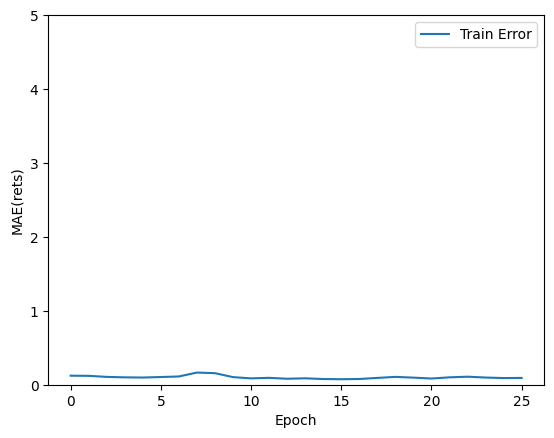

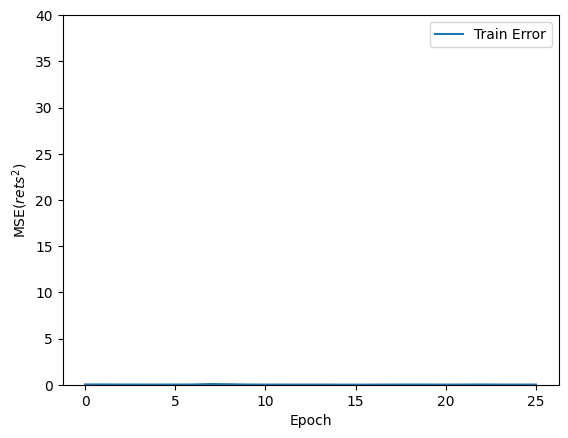

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAE(rets)')
  plt.plot(hist['epoch'], hist['mae'], label="Train Error")
  #plt.plot(hist['epoch'], hist['val_mae'], label="Validation Error")
  plt.legend()
  plt.ylim([0,5])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE($rets^2$)')
  plt.plot(hist['epoch'], hist['mse'], label="Train Error")
  #plt.plot(hist['epoch'], hist['val_mse'], label="Validation Error")
  plt.legend()
  plt.ylim([0,40])

plot_history(history)

25/25 [==============================] - 1s 14ms/step


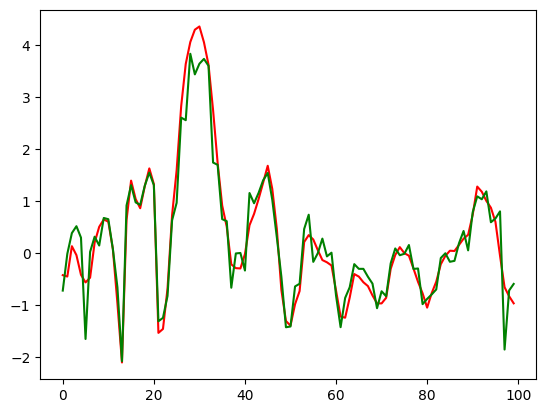

In [ ]:
pred, label = plot_predictions(model, X_train, y_train)
#predictions = model.predict(X_train)
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
mserror = mse(label, pred)
maerror = mae(label, pred)
mserror, maerror
predict = pd.DataFrame({'pred': pred.flatten()})
lbl = pd.DataFrame({'label': label.flatten()})
#df = predict#pred = pd.DataFrame({'pred': pred.flatten()})
df = lbl.join(predict)

In [ ]:
maerror, mserror

(0.18836766864718377, 0.06411961826359107)

In [ ]:
df

,label,pred
0,-0.727813,-0.874579
1,-0.019051,0.118249
2,0.378765,0.267617
3,0.511468,0.391498
4,0.291315,0.312360
...,...,...
895,-1.065557,-1.077651
896,-0.544666,-0.685718
897,-0.592353,-0.709675
898,-0.178235,-0.271396


4/4 [==============================] - 0s 15ms/step


(3.266603462477171, 1.591964792768665)

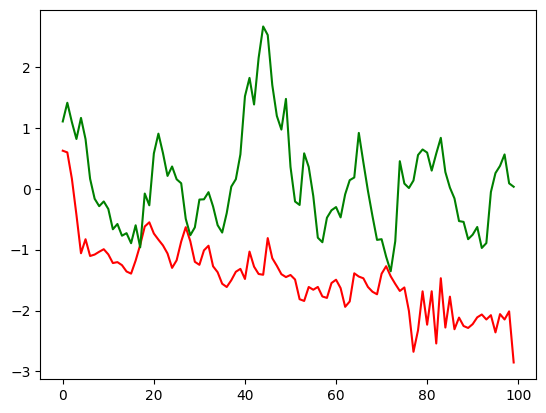

In [ ]:
pred_test, label_test = plot_predictions(model, X_test, y_test)
#predictions = model.predict(X_train)
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
mserror = mse(label_test, pred_test)
maerror = mae(label_test, pred_test)
mserror, maerror

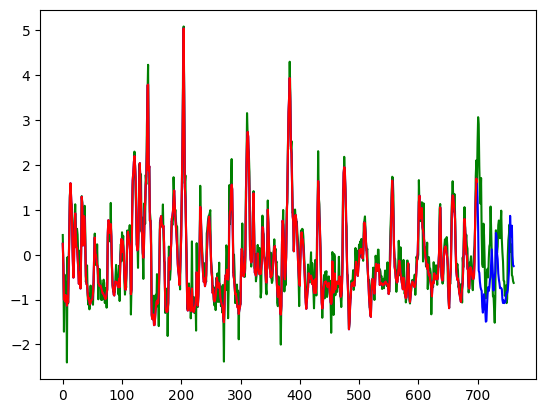

In [ ]:
pred_all = np.append(pred, pred_test )
label_all = np.append(label, label_test)
#plt.plot(pred_all, color='red')
plt.plot(label_all, color = 'green')
plt.plot(pred_all, color = 'blue')
plt.plot(pred, color='red')

In [ ]:

preds = pred_all.reshape(-1,1)
predictions = np.empty((812,1))
predictions[:] = np.nan
predictions[50:] = preds
#predictions = preds.shift(-50)
data_scaled.shape, preds.shape, predictions.shape

((812, 40), (762, 1), (812, 1))

In [ ]:
data_pred = np.hstack((data_scaled, predictions))
unscaled_pred = scaler.inverse_transform(data_pred)

In [ ]:
unscaled_predictions = unscaled_pred[:,-1]
unscaled_predictions.shape, unscaled_pred.shape
#u_p = unscaled_predictions.reshape(-1,1)
#u_p.shape
p = pd.Series(unscaled_predictions)
#p.shape

In [ ]:
p.rename('pred rets', inplace=True)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
807    6.186228
808    7.345330
809    4.077417
810    2.965905
811    2.908262
Name: pred rets, Length: 812, dtype: float64

In [ ]:
dta = pd.concat([dta, p], axis=1)

In [ ]:
dta

In [ ]:
rets = pd.DataFrame(data={"Predictions":pred_all.flatten(), "Actuals":label_all.flatten()})

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/models/DL_TA_TEST-signal-4/")

In [ ]:
#save all the data to file for further analysis
dta.to_csv("drive/MyDrive/Colab Notebooks/models/DL_TA_TEST-signal-4/DL_TA_TEST-signal-4.csv")
rets.to_csv("drive/MyDrive/Colab Notebooks/models/DL_TA_TEST-signal-4/DL_TA_TEST-signal-4-rets.csv")

In [ ]:
p.to_csv("drive/MyDrive/Colab Notebooks/models/DL_TA_TEST-signal-4/DL_TA_TEST-signal-4-pred_rets_unscaled.csv")

**STEP 4: BACKTESTING**

**STEP 5: FINAL STEP**
*   Save data, files, script and model
*   

